# Model Development - Degraded Chain    

**Author:** Colby Carter   

**Purpose:** In this exercise, we develop and compare several SVM classification approaches for degraded bike chains, each using a narrowing gridsearch across hyperparameters and with all-but-one example cross validation for conservative evaluation. Features are generated from the raw, 3D accelerometer recordings (m/s^2) across a number of mountain bikes.  

In [1]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier

We begin with pulling in our bootstrapped training set, for which our recording datasets have been processed into feature rows with different signal measures and Fast Fourier transformations.  

In [2]:
#import dataset of readings converted to features
featureDF = pd.read_csv('model/feature_dataset.csv')
featureDF.shape

(335, 26)

In [3]:
featureDF.head()

,Unnamed: 0,BikeID,Fixed,Component_Failure,Derailleur,Dirty_Chain,Roter,Steering_head,Wheel_Bearings,UnderLoad_X_pwr,...,UnderLoad_Y_std,UnderLoad_Y_skew,UnderLoad_Y_maxFFT,UnderLoad_Y_maxFreq,UnderLoad_Z_pwr,UnderLoad_Z_std,UnderLoad_Z_skew,UnderLoad_Z_maxFFT,UnderLoad_Z_maxFreq,UnderLoad_Z_chain
0,0,FN001-0,NaN,No probs with with this bike,0,0,0,0,0,0.002966,...,0.043659,-0.029433,0.007282,26.043406,0.004867,0.069762,0.253351,0.009374,57.095159,0.002530
1,1,FN001-1,NaN,No probs with with this bike,0,0,0,0,0,0.003566,...,0.048272,0.028978,0.009353,24.373957,0.005546,0.074472,-0.039635,0.015666,40.901503,0.003219
2,2,FN001-2,NaN,No probs with with this bike,0,0,0,0,0,0.003886,...,0.055228,0.046133,0.013604,14.190317,0.009056,0.095165,-0.154786,0.014323,84.808013,0.003424
3,3,FN001-3,NaN,No probs with with this bike,0,0,0,0,0,0.006571,...,0.079378,-0.295369,0.014722,14.357262,0.013304,0.115345,-0.648560,0.025257,42.237062,0.005237
4,4,FN001-4,NaN,No probs with with this bike,0,0,0,0,0,0.003855,...,0.050720,-0.043165,0.012621,14.190317,0.007128,0.084430,-0.101437,0.018719,43.071786,0.003455


In [4]:
#labels
y_chain = featureDF["Dirty_Chain"]
print("Positive dirty chain examples:", np.sum(y_chain))

Positive dirty chain examples: 71


In [5]:
#training features
x_feats = featureDF.iloc[:,9:]
x_feats.shape

(335, 17)

In [6]:
x_feats.head()

,UnderLoad_X_pwr,UnderLoad_X_std,UnderLoad_X_skew,UnderLoad_X_maxFFT,UnderLoad_X_maxFreq,UnderLoad_X_dCog,UnderLoad_Y_pwr,UnderLoad_Y_std,UnderLoad_Y_skew,UnderLoad_Y_maxFFT,UnderLoad_Y_maxFreq,UnderLoad_Z_pwr,UnderLoad_Z_std,UnderLoad_Z_skew,UnderLoad_Z_maxFFT,UnderLoad_Z_maxFreq,UnderLoad_Z_chain
0,0.002966,0.054461,-0.219428,0.006399,14.023372,0.001457,0.001906,0.043659,-0.029433,0.007282,26.043406,0.004867,0.069762,0.253351,0.009374,57.095159,0.002530
1,0.003566,0.059712,-0.173806,0.010743,14.190317,0.001909,0.002330,0.048272,0.028978,0.009353,24.373957,0.005546,0.074472,-0.039635,0.015666,40.901503,0.003219
2,0.003886,0.062340,-0.058981,0.020496,14.190317,0.002027,0.003050,0.055228,0.046133,0.013604,14.190317,0.009056,0.095165,-0.154786,0.014323,84.808013,0.003424
3,0.006571,0.081064,-0.044865,0.021452,14.357262,0.002457,0.006301,0.079378,-0.295369,0.014722,14.357262,0.013304,0.115345,-0.648560,0.025257,42.237062,0.005237
4,0.003855,0.062085,-0.025672,0.019990,14.190317,0.002100,0.002572,0.050720,-0.043165,0.012621,14.190317,0.007128,0.084430,-0.101437,0.018719,43.071786,0.003455


## Tuning with Cross Validation    

For each bike recording example, we train a model on all other (N-1) examples and make a prediction on that holdout example, taking the average accuracy across all examples.   

In [7]:
# helper functions

def oneVsAll(model, x, y):
    index = range(0, x.shape[0])
    numExamples = len(index)
    preds = []

    for i in index:
        train = x.drop(i, axis=0)
        labels = y.drop(i)
        model.fit(train, labels)
        preds.append(model.predict(np.array(x_feats.iloc[i]).reshape(1, -1))) #updated from x_scaled

    print("Accuracy:  ", accuracy_score(y, preds))
    print("Precision: ", precision_score(y, preds))
    print("Recall:    ", recall_score(y, preds))
    print("F1 score:  ", f1_score(y, preds))
    return confusion_matrix(y, preds)


def f1_looper(model, x, y):
    index = range(0, x.shape[0])
    numExamples = len(index)
    preds = []

    for i in index:
        train = x.drop(i, axis=0)
        labels = y.drop(i)
        model.fit(train, labels)
        preds.append(model.predict(np.array(x_feats.iloc[i]).reshape(1, -1))) #updated from x_scaled

    return f1_score(y, preds)


def f1Curve(c, loss, label, title = None):
    """
    Helper function for plotting.
    Args: c list, list of losses
    """
    fig, ax = plt.subplots(1,1,figsize = (12,6))
    ax.plot(c, loss, 'r--', label=label)
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Hyperparameter C')
    plt.ylabel('F1 (from CV)')
    if title:
        plt.title(title)
    plt.show()

## Baseline Linear SVM  

We begin with a simple baseline model using a linear SVM classifier.  

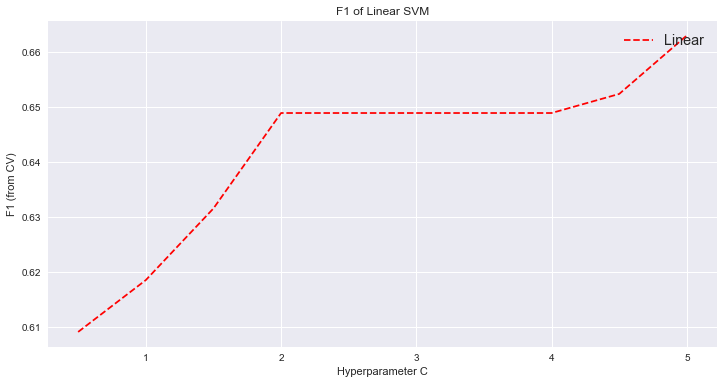

In [8]:
divisor = 2
c_values = [i/divisor for i in range(1, 11)]

scores = []

for c in c_values:
    linearSVM = Pipeline((
        ("scaler", StandardScaler()),
        ("linSVM", LinearSVC(penalty='l2', C=c, random_state=24, tol=1e-5, max_iter=50000, class_weight='balanced'))
        ))
    scores.append(f1_looper(linearSVM, x_feats, y_chain))

f1Curve(c_values, scores, "Linear", title = "F1 of Linear SVM")

In [9]:
linearSVM = Pipeline((
        ("scaler", StandardScaler()),
        ("linear", LinearSVC(penalty='l2', C=5, random_state=24, tol=1e-5, max_iter=50000, class_weight='balanced'))
        ))

oneVsAll(linearSVM, x_feats, y_chain)

Accuracy:   0.8149253731343283
Precision:  0.5398230088495575
Recall:     0.8591549295774648
F1 score:   0.6630434782608695


array([[212,  52],
       [ 10,  61]], dtype=int64)

## Polynomial Kernel    

To model more complex relationships, we use a kernel trick to estimate polynomial transformations/relationships and interactions across our feature sets.   

### Order = 2

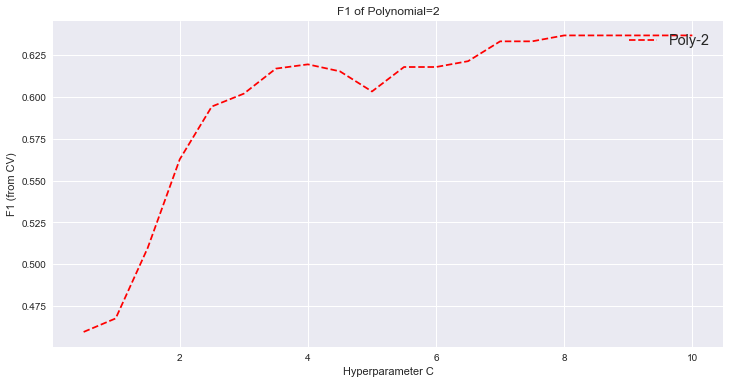

In [9]:
divisor = 2
c_values = [i/divisor for i in range(1, 21)]
scores = []

for c in c_values:
    polySVM = Pipeline((
        ("scaler", StandardScaler()),
        ("poly2", SVC(kernel='poly', C=c, degree=2, class_weight='balanced', gamma='scale'))
        ))
    scores.append(f1_looper(polySVM, x_feats, y_chain))

f1Curve(c_values, scores, "Poly-2", title = "F1 of Polynomial=2")

In [10]:
poly2 = Pipeline((
        ("scaler", StandardScaler()),
        ("poly2_svm", SVC(kernel='poly', C=4, degree=2, class_weight='balanced', gamma='scale'))
        ))

oneVsAll(poly2, x_feats, y_chain)

Accuracy:   0.7910447761194029
Precision:  0.504424778761062
Recall:     0.8028169014084507
F1 score:   0.6195652173913044


array([[208,  56],
       [ 14,  57]], dtype=int64)

### Order = 3

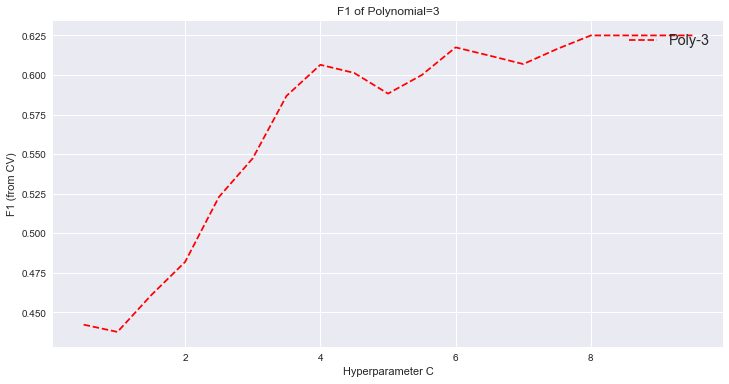

In [12]:
divisor = 2
c_values = [i/divisor for i in range(1, 20)]
scores = []

for c in c_values:
    polySVM = Pipeline((
        ("scaler", StandardScaler()),
        ("poly3", SVC(kernel='poly', C=c, degree=3, class_weight='balanced', gamma='scale'))
        ))
    scores.append(f1_looper(polySVM, x_feats, y_chain))

f1Curve(c_values, scores, "Poly-3", title = "F1 of Polynomial=3")

In [13]:
poly3 = Pipeline((
        ("scaler", StandardScaler()),
        ("poly3_svm", SVC(kernel='poly', C=4, degree=3, class_weight='balanced', gamma='scale'))
        ))

oneVsAll(poly3, x_feats, y_chain)

Accuracy:   0.817910447761194
Precision:  0.5595238095238095
Recall:     0.6619718309859155
F1 score:   0.6064516129032258


array([[227,  37],
       [ 24,  47]], dtype=int64)

### Order = 4

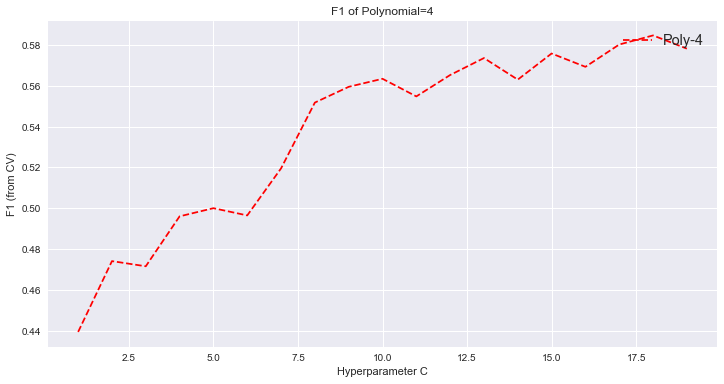

In [28]:
divisor = 1
c_values = [i/divisor for i in range(1, 20)]
scores = []

for c in c_values:
    polySVM = Pipeline((
        ("scaler", StandardScaler()),
        ("poly4", SVC(kernel='poly', C=c, degree=4, class_weight='balanced', gamma='scale'))
        ))
    scores.append(f1_looper(polySVM, x_feats, y_chain))

f1Curve(c_values, scores, "Poly-4", title = "F1 of Polynomial=4")

In [35]:
poly4 = Pipeline((
        ("scaler", StandardScaler()),
        ("poly4_svm", SVC(kernel='poly', C=10, degree=4, class_weight='balanced', gamma='scale'))
        ))

oneVsAll(poly4, x_feats, y_chain)

Accuracy:   0.8149253731343283
Precision:  0.5633802816901409
Recall:     0.5633802816901409
F1 score:   0.5633802816901409


array([[233,  31],
       [ 31,  40]], dtype=int64)

Regularized linear model does better than each polynomial model.

### Gaussian RBF

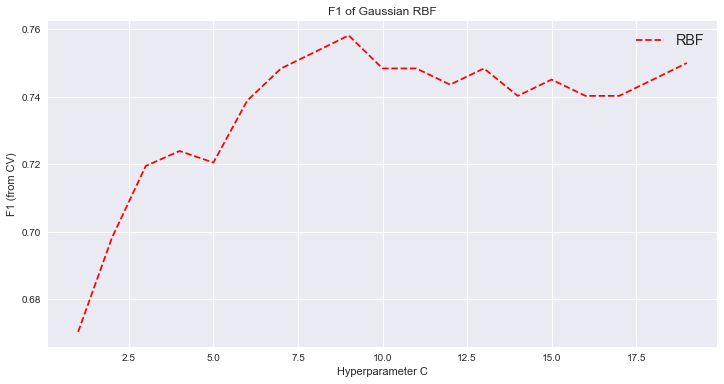

In [14]:
divisor = 1
c_values = [i/divisor for i in range(1, 20)]

scores = []

for c in c_values:
    rbfSVM = Pipeline((
        ("scaler", StandardScaler()),
        ("rbf", SVC(kernel='rbf', C=c, class_weight='balanced', gamma='scale'))
        ))
    scores.append(f1_looper(rbfSVM, x_feats, y_chain))

f1Curve(c_values, scores, "RBF", title = "F1 of Gaussian RBF")

In [15]:
rbfSVM = Pipeline((
        ("scaler", StandardScaler()),
        ("rbf", SVC(kernel='rbf', C=7.5, class_weight='balanced', gamma='scale'))
        ))

oneVsAll(rbfSVM, x_feats, y_chain)

Accuracy:   0.8805970149253731
Precision:  0.6867469879518072
Recall:     0.8028169014084507
F1 score:   0.7402597402597403


array([[238,  26],
       [ 14,  57]], dtype=int64)

**Result**: Gaussian RBF far outperforms all polynomial kernel models and the baseline linear model. This will be our selected model at the optimum lane width _C_ = 7.5.

## Save Model

In [16]:
from joblib import dump, load

chainSVM = rbfSVM
dump(chainSVM, 'model/chainSVM.joblib')

['model/chainSVM.joblib']

In [17]:
# test importing .joblib
importSVM = load('model/chainSVM.joblib')

In [18]:
# train accuracy
y_import = importSVM.predict(x_feats)
print("Precision: ", precision_score(y_chain, y_import))
print("Recall:    ", recall_score(y_chain, y_import))
print("F1 score:  ", f1_score(y_chain, y_import))
confusion_matrix(y_chain, y_import)

Precision:  0.8214285714285714
Recall:     0.971830985915493
F1 score:   0.8903225806451612


array([[249,  15],
       [  2,  69]], dtype=int64)